In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration/")

In [12]:
import torch
import numpy as np
import ml_collections
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from data.create_dataset import create_wikipedia_dataset, create_rocstory_dataset, create_glue_unsupervised_dataset
from data.preprocessing import text_preprocessor, unsupervised_preprocessor, supervised_preprocessor
from utils.util import dict_to_tensors, masked_mean, masked_std, set_seed, dict_to_cuda

In [142]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    #config.checkpoints_prefix = "wikipedia--encodings-prediction=x_0-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=0.1-lr=5e-05-min_lr=1e-05-identity_debug_600000_"
    #config.checkpoints_prefix = "wikipedia--encodings-prediction=x_0_x_t-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=0.1-lr=5e-05-min_lr=1e-05-_900000_"
    #config.checkpoints_prefix = "wikipedia--encodings-prediction=x_0_a_x_t-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=0.1-lr=5e-05-min_lr=1e-05-norm_repaired_900000_"
    
    config.checkpoints_prefix = "rocstory--encodings-prediction=x_0_a_x_t-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=0.1-lr=5e-05-min_lr=1e-05-norm_repaired_900000_"
    #config.checkpoints_prefix = "rocstory--encodings-prediction=x_0_a_x_t-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=32-clipgrad=0.1-lr=5e-05-min_lr=1e-05-norm_repaired_1400000_"
    #config.checkpoints_prefix = "rocstory--encodings-prediction=eps_a_x_t-loss=L_eps-enc=base-bert=base-kl_cf=0.0-seq_len=64-clipgrad=0.1-lr=5e-05-min_lr=1e-05-norm_repaired_1800000_"
    
    
    
    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 2000
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.prediction = "x_0_a_x_t"
    model.dataset = "rocstory"

    data = config.data = ml_collections.ConfigDict()
    data.config_path = "/home/vmeshchaninov/DiffusionTextGeneration/data/config.json"
    data.max_sequence_len = 64

    config.device = 'cuda:0'
    config.ddp = False
    config.seed = 0
    config.bert_config = None
    return config

In [143]:
config = create_config()
config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

seed = config.seed
set_seed(seed)

diffusion = DiffusionRunner(config, latent_mode="encodings", eval=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [124]:
max_sequence_len = 64
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
#dataset_wiki = create_wikipedia_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)
dataset_roc = create_rocstory_dataset(split="train", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [44]:
dataset_sst2 = create_glue_unsupervised_dataset(split="train", tokenizer=tokenizer, max_sequence_len=max_sequence_len, downstream_task="sst2")

sst2 is loaded


In [12]:
def compute_trace(x_t, t, mask):
    eps = torch.randn_like(x_t)
    with torch.enable_grad():
        x_t.requires_grad_(True)
        fn = get_x_t_next_drift(x_t, t, mask)
        fn_eps = torch.sum(fn * eps)
        grad_fn_eps = torch.autograd.grad(fn_eps, x_t)[0]
    x_t.requires_grad_(False)
    trace = torch.sum(grad_fn_eps * eps, dim=[1, 2])
    return trace

In [13]:
def prior_logp(z):
    shape = z.shape
    N = np.prod(shape[1:])
    return -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2)) / 2.

In [14]:
def get_x_t_next(x_t, vec_t, mask):
    params = diffusion.sde.sde(x_t, vec_t)
    drift, dif = params["drift"], params["diffusion"]
    dt = 1. / diffusion.diff_eq_solver.rsde.N
    
    score = diffusion.sde.calc_score(diffusion.score_estimator, x_t, vec_t, mask)["score"]
    dx = drift * dt - 0.5 * dif[:, None, None] ** 2 * score * dt
    x_t_next = x_t + dx
    return x_t_next

In [15]:
def get_x_t_next_drift(x_t, vec_t, mask):
    params = diffusion.sde.sde(x_t, vec_t)
    drift, dif = params["drift"], params["diffusion"]
    dt = 1. / diffusion.diff_eq_solver.rsde.N
    
    score = diffusion.sde.calc_score(diffusion.score_estimator, x_t, vec_t, mask)["score"]
    return drift - 0.5 * dif[:, None, None] ** 2 * score

In [228]:
batch_size = 32
loader = DataLoader(
            dataset_roc,
            batch_size=batch_size,
            num_workers=1,
            shuffle=False,
        )


for X in loader:
    break
X = dict_to_cuda(X)
embs = diffusion.sampler_emb({key:X[key].cuda() for key in ["input_ids", "attention_mask"]})
mask = X["attention_mask"]
torch.mean(masked_mean(embs, mask)), torch.mean(masked_std(embs, mask))

(tensor(-0.0004, device='cuda:0'), tensor(1.0035, device='cuda:0'))

In [27]:
set_seed(0)

probability = torch.zeros(batch_size).to("cuda:0")
probas = []

dt = 1 / diffusion.diff_eq_solver.sde.N
timesteps = torch.linspace(dt, diffusion.sde.T, diffusion.sde.N, device=diffusion.device)

x_0 = embs
vec_t = torch.ones(batch_size, device="cuda:0") * timesteps[0]
params = diffusion.sde.marginal_params_tensor(x_0, vec_t)
alpha, std = params["alpha"], params["std"]
x_t = x_0 * alpha + torch.randn_like(x_0) * std

set_seed(0)
with torch.no_grad():
    for t in tqdm(timesteps):
        vec_t = torch.ones(batch_size, device=t.device) * t
        proba = compute_trace(x_t, vec_t, mask) * dt
        probability += proba
        probas.append(proba)
        x_t = get_x_t_next(x_t, vec_t, mask)

100%|██████████| 2000/2000 [03:23<00:00,  9.84it/s]


In [205]:
from copy import deepcopy

In [206]:
def change(text_t, n):
    text_t = deepcopy(text_t)
    k = text_t.shape[1]
    for i in range(n):
        i = np.random.randint(0, k)
        text_t[0][i] = the_emb
    return text_t

In [235]:
text_t = X["input_ids"][:1]
mask_t = X["attention_mask"][:1]

In [239]:
t_t = [change(text_t, n)[0] for n in [0, 10, 20, 30, 50, 60]]
m_t = [mask_t[0] for n in [0, 10, 20, 30, 50, 60]]

In [240]:
t_t = torch.stack(t_t)
m_t = torch.stack(m_t)

In [241]:
embs = diffusion.sampler_emb({"input_ids":t_t.cuda(), "attention_mask":m_t.cuda()})
prob, x_t = diffusion.compute_likelihood(embs, m_t)

100%|██████████| 2001/2001 [01:04<00:00, 31.06it/s]


In [233]:
t_t

tensor([[  101,  4907,  1005,  1055,  3008,  2020,  2058, 11179,  1012,  4907,
          2001,  2058, 11179,  2004,  2092,  1012,  1996,  7435,  2409,  2010,
          3008,  2009,  2001,  4895, 20192, 24658,  2100,  1012,  2010,  3008,
          5319,  1998,  2787,  2000,  2191,  1037,  2689,  1012,  2027,  2288,
          3209,  1998,  4907,  2006,  1037,  8738,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  1996,  1005,  1996,  3008,  2020,  2058, 11179,  1012,  4907,
          2001,  2058, 11179,  2004,  2092,  1012,  1996,  1996,  2409,  2010,
          1996,  2009,  2001,  4895, 20192, 24658,  2100,  1012,  2010,  3008,
          5319,  1998,  2787,  2000,  2191,  1037,  1996,  1012,  2027,  2288,
          3209,  1998,  1996,  2006,  1037,  8738,  1012,   102,  1996,     0,
             0,     0,     0,  1996,     0,     0,  1996,     0,     0,     0,
             0

In [242]:
prob

tensor([-42117.9961, -51029.0664, -49491.8320, -50194.1016, -54874.3086,
        -57316.7500], device='cuda:0')

In [179]:
text_t

tensor([[  101,  4907,  1005,  1055,  3008,  2020,  2058, 11179,  1012,  4907,
          2001,  2058, 11179,  2004,  2092,  1012,  1996,  7435,  2409,  2010,
          3008,  2009,  2001,  4895, 20192, 24658,  2100,  1012,  2010,  3008,
          5319,  1998,  2787,  2000,  2191,  1037,  2689,  1012,  2027,  2288,
          3209,  1998,  4907,  2006,  1037,  8738,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]], device='cuda:0')

In [188]:
change(text_t, 10).shape

torch.Size([1, 64])

In [163]:
pred_embeddings = embs[0:1]
tokens = diffusion.pred_logits(pred_embeddings, X["input_ids"]).argmax(dim=-1)
text = diffusion.tokenizer.batch_decode(tokens)

In [167]:
prob, x_t = diffusion.compute_likelihood(pred_embeddings, mask[:1])

100%|██████████| 2001/2001 [00:57<00:00, 34.68it/s]


In [168]:
prob

tensor([-42128.9609], device='cuda:0')

In [184]:
the_emb = tokenizer("the")["input_ids"][1]

In [30]:
probability

tensor([13220.8789, 13217.3984, 14149.7529, 11865.4941], device='cuda:0')

In [15]:
probability

tensor([35131.2344, 40043.2070, 45367.1484, 39598.8867], device='cuda:0')

In [31]:
torch.mean(torch.norm(x_t, dim=[2]))

tensor(26.4028, device='cuda:0')

In [29]:
torch.mean(masked_std(x_t, mask)).item()

0.8860282897949219

In [32]:
26.4 * 26.4 / 768

0.9074999999999999

In [91]:
768 * 64

49152

In [21]:
211 * 211

44521

In [17]:
torch.norm(embs, dim=[1, 2])

tensor([211.0297, 221.2082, 209.0004, 226.1978], device='cuda:0')

In [82]:
probability

tensor([2679.7761, 2748.8811, 2406.3333, 2551.4888], device='cuda:0')

In [67]:
probability

tensor([1709.4534, 1720.7737, 1544.0601, 1619.6938], device='cuda:0')

In [29]:
probability

tensor([49151.5156, 49154.5195, 49160.0586, 49162.1445], device='cuda:0')

In [69]:
params = diffusion.sde.marginal_prob(x_t, vec_t)
mean, std = params["mean"], params["std"]
log_prob_normal(x_t, mean, std, mask)

tensor([-54231.6719, -42036.6055, -55274.5469, -55581.6602], device='cuda:0')

In [18]:
prior_logp(x_t)

tensor([-72055.4219, -66293.3828, -65803.6016, -67579.8047], device='cuda:0')

In [36]:
x_t.shape

torch.Size([4, 64, 768])

In [19]:
prior_logp(torch.randn(4, 64, 768).cuda())

tensor([-69735.4922, -69910.1094, -69587.7656, -69767.7109], device='cuda:0')

In [41]:
torch.mean(masked_std(x_t, mask))

tensor(0.6239, device='cuda:0', grad_fn=<MeanBackward0>)

# Latent

In [125]:
set_seed(0)

In [126]:
batch_size = 32
loader = DataLoader(
            dataset_roc,
            batch_size=batch_size,
            num_workers=1,
            shuffle=True,
        )

In [127]:
loader = iter(loader)

In [147]:
X = next(loader)
X = dict_to_cuda(X)

In [148]:
embs = diffusion.sampler_emb({key:X[key].cuda() for key in ["input_ids", "attention_mask"]})
mask = X["attention_mask"]
torch.mean(masked_mean(embs, mask)), torch.mean(masked_std(embs, mask))

(tensor(0.0003, device='cuda:0'), tensor(0.9990, device='cuda:0'))

In [149]:
x_t, norm_xt_roc = diffusion.generate_latent(embs, mask)

100%|██████████| 2001/2001 [00:53<00:00, 37.15it/s]


In [85]:
x_t, norm_xt_wiki = diffusion.generate_latent(embs, mask)

100%|██████████| 2001/2001 [00:53<00:00, 37.13it/s]


In [90]:
x_t, norm_xt_sst2 = diffusion.generate_latent(embs, mask)

100%|██████████| 2001/2001 [00:54<00:00, 36.88it/s]


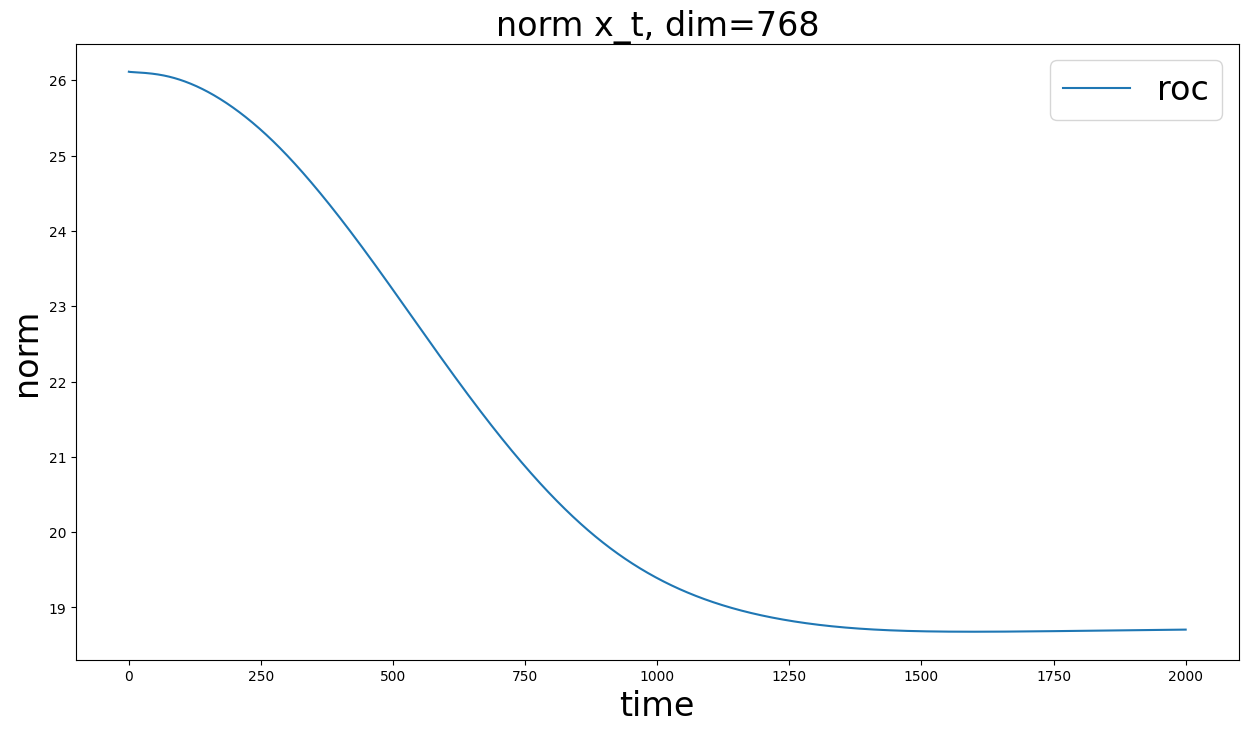

In [151]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('norm', fontsize=24)
plt.title("norm x_t, dim=768", fontsize=24)

plt.plot(norm_xt_roc, label="roc")

plt.legend(fontsize=24)
plt.show()

In [138]:
def masked_norm(z, mask):
    return torch.sum(torch.norm(z, dim=2) * mask) / torch.sum(mask)

In [141]:
masked_norm(embs, mask)

tensor(27.3686, device='cuda:0')

In [140]:
torch.mean(torch.norm(x_t, dim=2))

tensor(18.7708, device='cuda:0')

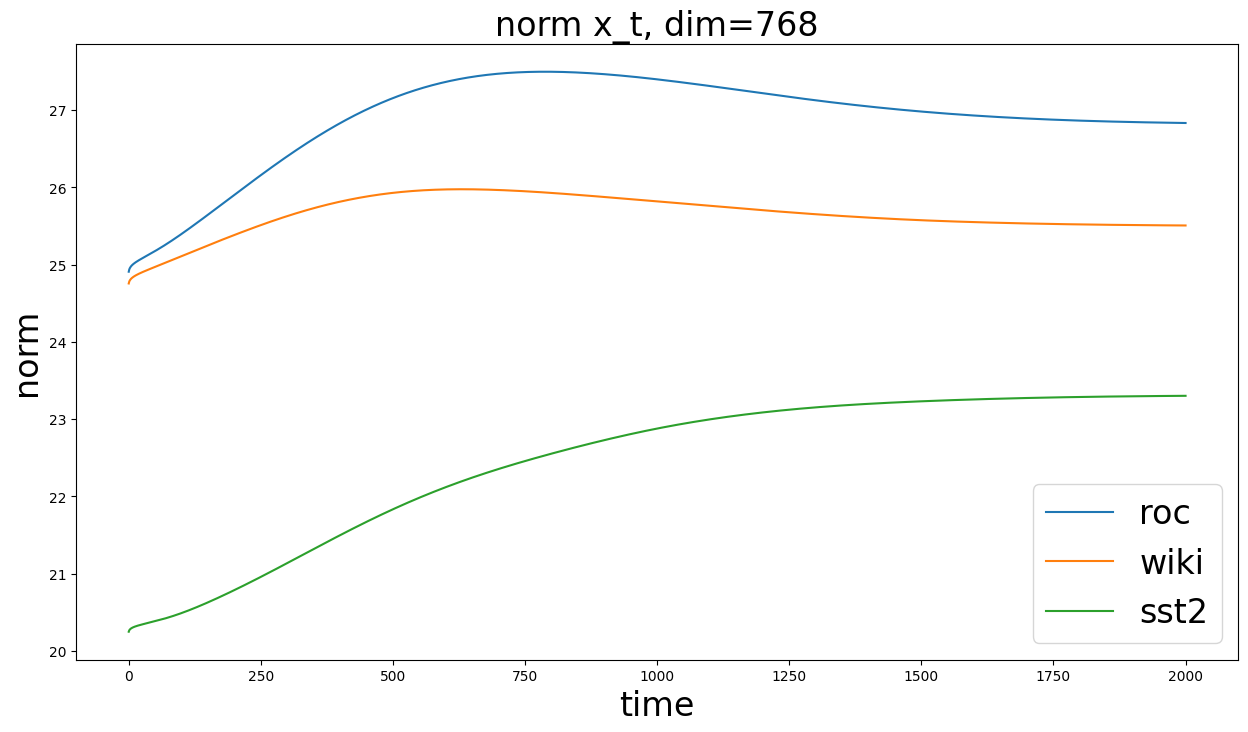

In [91]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('norm', fontsize=24)
plt.title("norm x_t, dim=768", fontsize=24)

plt.plot(norm_xt_roc, label="roc")
plt.plot(norm_xt_wiki, label="wiki")
plt.plot(norm_xt_sst2, label="sst2")

plt.legend(fontsize=24)
plt.show()

In [33]:
26.4 / np.sqrt(768)

0.9526279441628825

In [34]:
torch.mean(torch.norm(embs, dim=[2]))

tensor(26.3547, device='cuda:0')